In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 读数据

In [4]:
option_data = pd.read_csv("option_data.csv")
S_data = pd.read_csv("price_data.csv")

C:\Users\yigaa\AppData\Local\Temp\ipykernel_17240\1663855361.py:1: DtypeWarning: Columns (23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  option_data = pd.read_csv("option_data.csv")


# 处理

In [5]:
option_data = option_data.query("(cp_flag=='C' & 0.95>delta>0.05)|(cp_flag=='P' & -0.05>delta>-0.95)")

In [6]:
cols_to_check = ['best_bid', 'best_offer', 'impl_volatility', 'delta', 'gamma', 'vega', 'theta']
# 找到在指定列中有空值的行
rows_with_nan = option_data[option_data[cols_to_check].isnull().any(axis=1)]

# 提取这些行对应的唯一 symbol 列表
symbols_with_nan = rows_with_nan['symbol'].unique()
symbols_with_nan

option_data = option_data[~option_data['symbol'].isin(symbols_with_nan)]

In [7]:
option_data["f_t"] = option_data.eval("(best_bid+best_offer)/2")
option_data = option_data.merge(pd.pivot(option_data,columns="symbol",index="date",values="f_t").shift(1).stack().reset_index(),on=["date","symbol"],how="left")
l = list(option_data.columns.copy())
l[-1] = "f_t_minus_1"
option_data.columns = l

In [9]:
S_data['S_t'] = S_data["close"]#.pct_change()+1
S_data['S_t_minus_1'] = S_data.shift(1)['close']

In [10]:
data = option_data.merge(S_data[["date","S_t",'S_t_minus_1']],on=["date"],how="left")[["date","symbol","exdate","cp_flag","exercise_style","S_t",'S_t_minus_1',"f_t_minus_1","f_t","delta","gamma","vega","theta","strike_price"]]

In [11]:
data.dropna(inplace=True)

In [12]:
data.date = pd.to_datetime(data.date)
data.exdate = pd.to_datetime(data.exdate)
data['maturity'] = (data.exdate - data.date).dt.days/365

maturity_bucket = np.array([30,60,91,122,182,365])/365

data['maturity_group'] = data['maturity'].apply(lambda x: np.sum(x > maturity_bucket))
data['delta_group'] = round(data['delta']*10)/10#0.05四舍五入
data['month'] = data['date'].dt.month
data['ym'] = data.date.astype(str).str[0:7]

# 计算abc

In [14]:
def f_regression(x,df,window):
    #window = 1#单位：月
    #计算上36个月开始日期和结束日期
    start_date = (x.date.iloc[0] - pd.DateOffset(months=window)).replace(day=1)#36个月前第一天
    end_date = (x.date.iloc[0]).replace(day=1)- pd.DateOffset(days=1)#上个月最后一天

    loc_df = df[(df.date>=start_date) & (df.date<=end_date) & (df.cp == x.cp.iloc[0])]
    #创建特征123+target
    X = loc_df["coeffi"].to_frame()
    X["coeffi2"] = X["coeffi"]*(loc_df["delta"])
    X["coeffi3"] = X["coeffi2"]*(loc_df["delta"])
    #X["target"] = loc_df["f_t"] / loc_df["f_t_minus_1"] -1 - loc_df["delta"]*(loc_df["S_t"]/loc_df["S_t_minus_1"]-1)#normalized?不然截距项可能不太是0？
    X["target"] = loc_df["f_t"] - loc_df["f_t_minus_1"] - loc_df["delta"]*(loc_df["S_t"]-loc_df["S_t_minus_1"])
    X.dropna(inplace=True)
    y = X['target']
    X.drop('target',inplace=True,axis=1)
    if len(X)>0:#判断是否有数据可以计算
        model = LinearRegression(fit_intercept=False)#去掉截距项？
        model.fit(X, y)
        #print(x)
        temp_index = df[df['0'].isin(x['0'].values)].index.copy()
        #print(temp_index,x['0'].values)
        df.loc[temp_index,["a","b","c"]] = model.coef_     
        return model.coef_
    else:
        return np.nan
    
def f_abc(df):
    window = 36#单位：月
    df["coeffi"] = (df["vega"]/ ((df["maturity"])**0.5*df["S_t"]))*(df["S_t"]-df["S_t_minus_1"])#normalized S_t_minus_1 = 1?
    #df["coeffi"] = (df["vega"]/ ((df["maturity"])**0.5*df["S_t"]/df["S_t_minus_1"]))*(df["S_t"]/df["S_t_minus_1"]-1)
    #df['ym'] = df.date.astype(str).str[0:7]
    df[["a","b","c"]] = np.nan
    df["cp"] = df["cp_flag"]
    return df.groupby(["ym","cp_flag"]).apply(f_regression,df,window)#reset_pivot_df.groupby("ym").apply(lambda x:pivot_df[((x.date.iloc[0] - pd.DateOffset(months=window)).replace(day=1)):((x.date.iloc[0]).replace(day=1)- pd.DateOffset(days=1))].mean().mean())


In [15]:
data = data.reset_index()
l = list(data.columns)
l[0] = "0"
data.columns = l

In [16]:
result = f_abc(data)#data)

C:\Users\yigaa\AppData\Local\Temp\ipykernel_17240\350842475.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(["ym","cp_flag"]).apply(f_regression,df,window)#reset_pivot_df.groupby("ym").apply(lambda x:pivot_df[((x.date.iloc[0] - pd.DateOffset(months=window)).replace(day=1)):((x.date.iloc[0]).replace(day=1)- pd.DateOffset(days=1))].mean().mean())


<Axes: xlabel='date'>

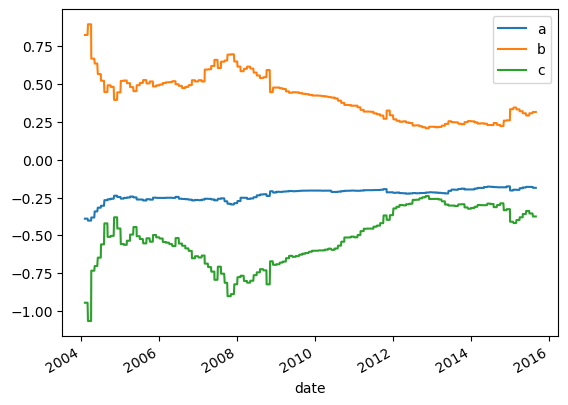

In [17]:
data.query("cp_flag=='C' & date>'2004'")[["date","a","b","c"]].drop_duplicates("date").set_index("date").plot()

In [19]:
data.query("symbol=='SXB.RJ'&cp_flag=='P'").sort_values('date')

,0,date,symbol,exdate,cp_flag,exercise_style,S_t,S_t_minus_1,f_t_minus_1,f_t,...,maturity,maturity_group,delta_group,month,ym,coeffi,a,b,c,cp
183,510,2004-01-05,SXB.RJ,2004-06-19,P,E,1122.22,1108.48,11.30,9.60,...,0.454795,4,-0.1,1,2004-01,2.630043,NaN,NaN,NaN,P
448,777,2004-01-06,SXB.RJ,2004-06-19,P,E,1123.67,1122.22,9.60,8.10,...,0.452055,4,-0.1,1,2004-01,0.258049,NaN,NaN,NaN,P
707,1040,2004-01-07,SXB.RJ,2004-06-19,P,E,1126.33,1123.67,8.10,7.30,...,0.449315,4,-0.1,1,2004-01,0.448761,NaN,NaN,NaN,P
967,1303,2004-01-08,SXB.RJ,2004-06-19,P,E,1131.92,1126.33,7.30,6.30,...,0.446575,4,-0.1,1,2004-01,0.873135,NaN,NaN,NaN,P
1228,1571,2004-01-09,SXB.RJ,2004-06-19,P,E,1121.86,1131.92,6.30,7.80,...,0.443836,4,-0.1,1,2004-01,-1.771719,NaN,NaN,NaN,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804415,835930,2010-02-05,SXB.RJ,2010-06-19,P,E,1066.19,1063.11,26.70,26.55,...,0.367123,4,-0.2,2,2010-02,0.934398,-0.257738,-0.506107,-0.390162,P
805234,836764,2010-02-08,SXB.RJ,2010-06-19,P,E,1056.74,1066.19,26.55,28.50,...,0.358904,4,-0.2,2,2010-02,-2.960782,-0.257738,-0.506107,-0.390162,P
806040,837575,2010-02-09,SXB.RJ,2010-06-19,P,E,1070.52,1056.74,28.50,24.95,...,0.356164,4,-0.2,2,2010-02,4.084816,-0.257738,-0.506107,-0.390162,P
806842,838399,2010-02-10,SXB.RJ,2010-06-19,P,E,1068.13,1070.52,24.95,24.95,...,0.353425,4,-0.2,2,2010-02,-0.710829,-0.257738,-0.506107,-0.390162,P


<Axes: xlabel='date'>

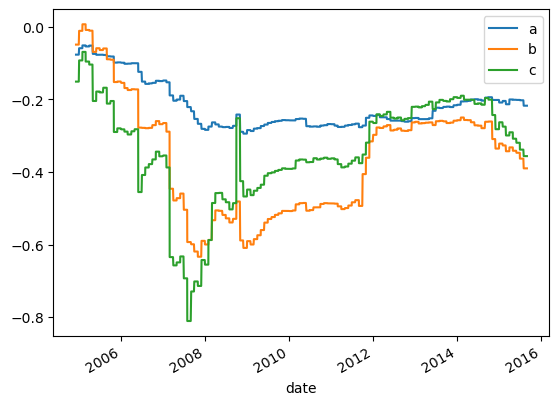

In [20]:
data.query("cp_flag=='P' & '2004-12-06'<date<'2015-12-14'")[["date","a","b","c"]].drop_duplicates("date").set_index("date").plot()

# 计算MV

In [21]:
def f_MV_delta(data):
    return data["delta"] + (data["vega"]/ ((data["maturity"])**0.5*data["S_t"]))*(data["a"]+data["b"]*data["delta"]+data["c"]*data["delta"]*data["delta"])
data["MV_delta"] = f_MV_delta(data)

# 计算gain

In [22]:
SSE_MV = data.groupby(["delta_group","exercise_style","cp_flag"]).apply(lambda x:((x["f_t"]-x["f_t_minus_1"] - x["MV_delta"]*(x["S_t"]-x["S_t_minus_1"]))**2).sum()).reset_index()
SSE_BS = data.groupby(["delta_group","exercise_style","cp_flag"]).apply(lambda x:((x["f_t"]-x["f_t_minus_1"] - x["delta"]*(x["S_t"]-x["S_t_minus_1"]))**2).sum()).reset_index()
SSE = SSE_MV.merge(SSE_BS,on=['delta_group', 'exercise_style', 'cp_flag'])
SSE.columns = ['delta_group', 'exercise_style', 'cp_flag']+["SSE_MV","SSE_BS"]
SSE["GAIN"] = 1 - SSE["SSE_MV"]/SSE["SSE_BS"]

C:\Users\yigaa\AppData\Local\Temp\ipykernel_17240\2680075421.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  SSE_MV = data.groupby(["delta_group","exercise_style","cp_flag"]).apply(lambda x:((x["f_t"]-x["f_t_minus_1"] - x["MV_delta"]*(x["S_t"]-x["S_t_minus_1"]))**2).sum()).reset_index()
C:\Users\yigaa\AppData\Local\Temp\ipykernel_17240\2680075421.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  SSE_B

In [23]:
mm = ((round(SSE.groupby(["cp_flag","delta_group"])["GAIN"].mean()*100,1)).astype(str)+"%").unstack(0)

In [24]:
mm

cp_flag,C,P
delta_group,,
-0.9,NaN,1.8%
-0.8,NaN,4.2%
-0.7,NaN,6.5%
-0.6,NaN,8.7%
-0.5,NaN,12.3%
-0.4,NaN,16.7%
-0.3,NaN,21.4%
-0.2,NaN,25.8%
-0.1,NaN,28.8%
